# ecoindex.pca_evaluation: complete usage guide
This notebook demonstrates every public function in `pca_evaluation.py` using the example processed data and small synthetic examples. Covered APIs:
- build_groups_from_labels
- build_groups_from_quantiles
- prepare_feature_matrix
- permutation_manova_euclidean
- evaluate_pca_assessment (wrapper)
- loss_from_result
- directional_mean_permutation_test (one-sided)
- evaluate_directional_mean_test (wrapper)

### What the next cell does (setup/imports)
- Sets project/data/artifact/src paths.
- Ensures local `src` is on `sys.path` so notebooks import the in-repo `ecoindex`.
- Imports and reloads `ecoindex` and `ecoindex.pca_evaluation` so edits are picked up.
- Prints file path to confirm we’re using the local package.

In [13]:
# 1) Setup and Imports
import os, sys, json, math, importlib
import numpy as np
import pandas as pd

PROJECT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(PROJECT_DIR, "data", "processed")
ART_DIR = os.path.join(PROJECT_DIR, "artifacts")
SRC_DIR = os.path.join(PROJECT_DIR, "src")
os.makedirs(ART_DIR, exist_ok=True)
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import ecoindex
import ecoindex.pca_evaluation as pca_eval
ecoindex = importlib.reload(ecoindex)
pca_eval = importlib.reload(pca_eval)
from ecoindex import (
    build_groups_from_labels,
    build_groups_from_quantiles,
    prepare_feature_matrix,
    permutation_manova_euclidean,
    evaluate_pca_assessment,
    loss_from_result,
    evaluate_directional_mean_test,
    directional_mean_permutation_test,
    get_block, wrap_columns,
)
print("ecoindex file:", ecoindex.__file__)

ecoindex file: /Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/__init__.py


### What this code does (load data)
- Reads the processed CSV into a MultiIndex DataFrame with (block, subblock, var).
- Sets StationID as the index and prints shape + preview.

In [14]:
# 2) Load Example Data
csv_path = os.path.join(DATA_DIR, "master_pollution_rank.csv")
raw = pd.read_csv(csv_path, header=[0,1,2], index_col=0)
raw.index.name = "StationID"
if isinstance(raw.columns, pd.MultiIndex) and raw.columns.nlevels == 3:
    raw.columns = pd.MultiIndex.from_tuples(raw.columns, names=["block","subblock","var"])
master = raw
print("master shape:", master.shape)
master.head(2)

master shape: (104, 106)


block      chemical                                                      \
subblock        raw                                                       
var         1234TCB   1245TCB    Al     As     Bi     Ca      Cd     Co   
StationID                                                                 
A10        0.835583  0.775732  3041  1.939  18.45  28170  0.2950  2.723   
A23        0.639983  0.697265  4483  2.512  17.03  42110  0.3986  4.009   

block                     ...                                \
subblock                  ...      logz                       
var            Cr     Cu  ...     ppDDD     ppDDE total_PCB   
StationID                 ...                                 
A10         8.766  17.64  ... -0.190979 -0.343200 -0.397416   
A23        10.850  17.28  ...  0.077590  0.137696  0.365410   

block                    pollution                             \
subblock  sumreal_by_logz_chemical                              
var                        SumReal   Quality SumReal_Shuffled   
StationID                                                       
A10                       5.989604    medium        -4.079840   
A23                       6.911119  degraded         7.844743   

block                                                  
subblock                   2006_rank                   
var       Quality_Shuffled      Rank  rank    Quality  
StationID                                              
A10              reference      54.0  14.0  reference  
A23               degraded      79.0  38.0     medium  

[2 rows x 106 columns]

### What this code does (build groups)
- Uses pollution labels (Quality) if present; else quantile groups from SumReal.
- Produces categorical Series aligned to master index.

In [15]:
# Fill NaN values in the Quality column with 'medium'
master[("pollution", "2006_rank", "Quality")] = master[("pollution", "2006_rank", "Quality")].fillna('medium')
print("Filled NaN values in Quality column with 'medium'")
print("Quality value counts:")
print(master['pollution']['2006_rank']['Quality'].value_counts())

Filled NaN values in Quality column with 'medium'
Quality value counts:
Quality
medium       64
reference    20
degraded     20
Name: count, dtype: int64


### What this code does (prepare features)
- Extracts features from master[("chemical", subblock)], imputes NaNs with column means, and z-scores columns.
- Returns numpy arrays (n×p) with aligned sample index arrays.

In [16]:
# 3) Group Builders: labels and quantiles
try:
    g_labels = build_groups_from_labels(master, pollution_block="pollution",
                                        pollution_subblock="sumreal_by_logz_chemical",
                                        label_var='Quality')
    print("Labels found:", g_labels.cat.categories.tolist())
except Exception as e:
    g_labels = None
    print("Labels not found:", e)

try:
    g_quant = build_groups_from_quantiles(master, pollution_block="pollution",
                                          pollution_subblock="sumreal_by_logz_chemical",
                                          score_var='SumReal')
    print("Quantile groups:", g_quant.cat.categories.tolist())
except Exception as e:
    g_quant = None
    print("Quantile groups not available:", e)

Labels found: ['degraded', 'medium', 'reference']
Quantile groups: ['bottom', 'middle', 'top']


In [17]:
X_raw = None
idx_raw = None
varnames_raw = None
X_logz = None
idx_logz = None
varnames_logz = None

X_raw, idx_raw = prepare_feature_matrix(master, block="taxa", subblock="hellinger",
                                        variables=master['taxa']['hellinger'].columns,
                                        standardize=True)
varnames_raw = list(master[("taxa", "hellinger")].columns)
print("X_raw:", X_raw.shape, "| vars:", len(varnames_raw), "| first 3:", varnames_raw[:3])

# Choose available feature matrix and groups
if X_raw is not None and g_labels is not None and len(np.intersect1d(idx_raw, g_labels.index)) > 5:
    idx = np.intersect1d(idx_raw, g_labels.index)
    X = X_raw[[i in set(idx) for i in idx_raw]]
    groups = g_labels.loc[idx]
    vars_ = varnames_raw

X_raw: (104, 16) | vars: 16 | first 3: ['Acari', 'Amphipoda', 'Caenis']


/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/pca_evaluation.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = master[(block, subblock)]
/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_7962/1397235651.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  varnames_raw = list(master[("taxa", "hellinger")].columns)


### What this code does (direct PERMANOVA) and what shapes the F plot
- Intersects sample indices for X and groups and runs permutation_manova_euclidean.
- F-null is affected by:
  - Feature scaling and variables used in X.
  - Group sizes/imbalance and the number of groups k.
  - Number of permutations (hist smoothness, p precision).
  - df_between=k-1 and df_within=n-k.

In [18]:
# 4) Prepare Feature Matrices
# Try raw first; if missing, try logz.
    
try:
    X_raw, idx_raw = prepare_feature_matrix(master, block="chemical", subblock="raw", variables=None, standardize=True)
    varnames_raw = list(master[("chemical", "raw")].columns)
    print("X_raw:", X_raw.shape, "| vars:", len(varnames_raw), "| first 3:", varnames_raw[:3])
except Exception as e:
    print("Raw features not available:", e)

try:
    X_logz, idx_logz = prepare_feature_matrix(master, block="chemical", subblock="logz", variables=None, standardize=True)
    varnames_logz = list(master[("chemical", "logz")].columns)
    print("X_logz:", X_logz.shape, "| vars:", len(varnames_logz), "| first 3:", varnames_logz[:3])
except Exception as e:
    print("Logz features not available:", e)

X_raw: (104, 30) | vars: 30 | first 3: ['1234TCB', '1245TCB', 'Al']
X_logz: (104, 30) | vars: 30 | first 3: ['1234TCB', '1245TCB', 'Al']


/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/pca_evaluation.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = master[(block, subblock)]
/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_7962/2078669376.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  varnames_raw = list(master[("chemical", "raw")].columns)
/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/pca_evaluation.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = master[(block, subblock)]
/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_7962/2078669376.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  varnames_logz = list(master[("chemical", "logz")].columns)


### What this code does (wrapper + loss)
- Builds X and groups inside `evaluate_pca_assessment` and runs the permutation test.
- Reports pseudo-F, p, R2, df, and computes loss = -log10(p)*R2.

In [19]:
# 5) Direct PERMANOVA-like test
import numpy as np

# Choose available feature matrix and groups
X = None
idx = None
vars_ = None
groups = None

if X_raw is not None and g_labels is not None and len(np.intersect1d(idx_raw, g_labels.index)) > 5:
    idx = np.intersect1d(idx_raw, g_labels.index)
    X = X_raw[[i in set(idx) for i in idx_raw]]
    groups = g_labels.loc[idx]
    vars_ = varnames_raw
elif X_logz is not None and g_labels is not None and len(np.intersect1d(idx_logz, g_labels.index)) > 5:
    idx = np.intersect1d(idx_logz, g_labels.index)
    X = X_logz[[i in set(idx) for i in idx_logz]]
    groups = g_labels.loc[idx]
    vars_ = varnames_logz
elif X_raw is not None and g_quant is not None and len(np.intersect1d(idx_raw, g_quant.index)) > 5:
    idx = np.intersect1d(idx_raw, g_quant.index)
    X = X_raw[[i in set(idx) for i in idx_raw]]
    groups = g_quant.loc[idx]
    vars_ = varnames_raw
elif X_logz is not None and g_quant is not None and len(np.intersect1d(idx_logz, g_quant.index)) > 5:
    idx = np.intersect1d(idx_logz, g_quant.index)
    X = X_logz[[i in set(idx) for i in idx_logz]]
    groups = g_quant.loc[idx]
    vars_ = varnames_logz
else:
    raise RuntimeError("Need at least one feature matrix and group vector with overlapping index")

res_perm = permutation_manova_euclidean(X, groups.values, permutations=499)
print(res_perm)

EvalResult(groups=0        medium
1      degraded
2        medium
3        medium
4        medium
         ...   
99       medium
100    degraded
101    degraded
102      medium
103    degraded
Length: 104, dtype: category
Categories (3, object): ['degraded', 'medium', 'reference'], F_stat=8.06478886421225, p_value=0.002, R2=0.13770712779160174, df_between=2, df_within=101, n_perm=499, method='permutation_euclidean', meta={'levels': ['degraded', 'medium', 'reference']})


In [20]:
# 6) Wrapper evaluation + loss
# Prefer labels if available, else quantiles
group_mode = 'labels' if g_labels is not None else 'quantiles'
wrapper = evaluate_pca_assessment(master, features_block="chemical", features_subblock=("raw" if X_raw is not None else "logz"), group_mode=group_mode, permutations=499)
print(wrapper)
print("loss:", loss_from_result(wrapper))

EvalResult(groups=StationID
A10       medium
A23     degraded
A27       medium
A28       medium
A29       medium
          ...   
S99       medium
UBC1    degraded
UCC1    degraded
UCE1      medium
UJC1    degraded
Length: 104, dtype: category
Categories (3, object): ['degraded', 'medium', 'reference'], F_stat=8.06478886421225, p_value=0.002, R2=0.1377071277916017, df_between=2, df_within=101, n_perm=499, method='permutation_euclidean', meta={'levels': ['degraded', 'medium', 'reference'], 'features_block': 'chemical', 'features_subblock': 'raw', 'pollution_block': 'pollution', 'pollution_subblock': 'sumreal_by_logz_chemical', 'group_mode': 'labels'})
loss: 0.37166740729279996


/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/pca_evaluation.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = master[(block, subblock)]


In [21]:
# 7) Directional tests
# Determine reference/degraded labels if we have labels; otherwise use quantiles (low vs high)
ref_label = None
deg_label = None
group_vec = None
X_for_dir = None
vars_for_dir = None

if g_labels is not None:
    cats = list(g_labels.cat.categories)
    # Prefer exact names if present
    ref_candidates = [c for c in cats if str(c).lower().startswith("ref")]
    deg_candidates = [c for c in cats if str(c).lower().startswith("deg")]
    ref_label = ref_candidates[0] if ref_candidates else min(cats)
    deg_label = deg_candidates[0] if deg_candidates else max(cats)
    group_vec = g_labels
elif g_quant is not None:
    ref_label = "bottom"
    deg_label = "top"
    group_vec = g_quant
else:
    raise RuntimeError("No groups to run directional test")

# choose features
if X_logz is not None:
    X_for_dir = X_logz
    idx_for_dir = idx_logz
    vars_for_dir = varnames_logz
elif X_raw is not None:
    X_for_dir = X_raw
    idx_for_dir = idx_raw
    vars_for_dir = varnames_raw
else:
    raise RuntimeError("No feature matrix available for directional test")

# align by index array
shared = np.intersect1d(idx_for_dir, group_vec.index)
mask = [i in set(shared) for i in idx_for_dir]
X_use = X_for_dir[mask]
g_use = group_vec.loc[shared]

# Direct API: average mode
dir_res_avg = directional_mean_permutation_test(X_use, g_use.values, reference_label=ref_label, degraded_label=deg_label, var_names=vars_for_dir, standardize=True, permutations=499, mode="average")
print("Directional (average) p=", dir_res_avg.p_value)

# Direct API: min mode
dir_res_min = directional_mean_permutation_test(X_use, g_use.values, reference_label=ref_label, degraded_label=deg_label, var_names=vars_for_dir, standardize=True, permutations=499, mode="min")
print("Directional (min) p=", dir_res_min.p_value)

# Wrapper convenience
dir_wrap = evaluate_directional_mean_test(master, features_block="chemical", features_subblock=("logz" if X_logz is not None else "raw"), group_mode=('labels' if g_labels is not None else 'quantiles'), reference_label=ref_label if g_labels is not None else None, degraded_label=deg_label if g_labels is not None else None, variables=None, standardize=True, permutations=499, mode="average")
print(dir_wrap)
top_vars = sorted(dir_wrap.per_variable, key=lambda k: dir_wrap.per_variable[k].get('z', 0), reverse=True)[:5]
print("Top contributing vars:", top_vars)

Directional (average) p= 0.002


/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/pca_evaluation.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = master[(block, subblock)]
/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/pca_evaluation.py:454: PerformanceWarning: indexing past lexsort depth may impact performance.
  var_names = list(master[(features_block, features_subblock)].columns)


Directional (min) p= 0.02
DirMeanTestResult(statistic=1.0609697428537035, p_value=0.002, per_variable={'1234TCB': {'mean_ref': -0.6676936810281523, 'mean_deg': 0.35333661032303165, 'diff': 1.021030291351184, 'z': 0.8821028988646492}, '1245TCB': {'mean_ref': -0.7156415142678058, 'mean_deg': 1.2311254826881723, 'diff': 1.946766996955978, 'z': 1.3536423710464083}, 'Al': {'mean_ref': -0.6052533297367775, 'mean_deg': 0.6715967405364976, 'diff': 1.2768500702732752, 'z': 1.0733097742411277}, 'As': {'mean_ref': -0.1630669771326108, 'mean_deg': 0.2686647876042494, 'diff': 0.4317317647368602, 'z': 0.4641919825233376}, 'Bi': {'mean_ref': 0.027922604419141645, 'mean_deg': 0.27193186537314473, 'diff': 0.24400926095400308, 'z': 0.27312225732643775}, 'Ca': {'mean_ref': -1.0676647157738426, 'mean_deg': 0.8288884679686006, 'diff': 1.8965531837424432, 'z': 1.406718026715452}, 'Cd': {'mean_ref': -0.8909318200667777, 'mean_deg': 1.0762799532338412, 'diff': 1.967211773300619, 'z': 1.393291382390709}, 'Co':

In [22]:
# 8) Save compact artifact
from dataclasses import asdict
from pathlib import Path
import json

artifacts_dir = (Path.cwd().parent / "artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Normalize top_vars to list of var names
if isinstance(top_vars, list):
    if len(top_vars) > 0 and isinstance(top_vars[0], str):
        top_var_names = top_vars
    else:
        # list of dicts
        top_var_names = [d.get("var") for d in top_vars]
else:
    top_var_names = []

summary = {
    "perm_direct": {
        "F": getattr(res_perm, "F_stat", None),
        "p": getattr(res_perm, "p_value", None),
        "R2": getattr(res_perm, "R2", None),
        "n_perm": getattr(res_perm, "n_perm", None),
        "method": getattr(res_perm, "method", None),
    },
    "perm_wrapper": {
        "F": getattr(wrapper, "F_stat", None),
        "p": getattr(wrapper, "p_value", None),
        "R2": getattr(wrapper, "R2", None),
        "n_perm": getattr(wrapper, "n_perm", None),
        "method": getattr(wrapper, "method", None),
        "loss": float(loss_from_result(wrapper)) if wrapper else None,
    },
    "dir_avg": {
        "stat": getattr(dir_res_avg, "statistic", None),
        "p": getattr(dir_res_avg, "p_value", None),
        "n_perm": getattr(dir_res_avg, "n_perm", None),
        "mode": getattr(dir_res_avg, "mode", None),
    },
    "dir_min": {
        "stat": getattr(dir_res_min, "statistic", None),
        "p": getattr(dir_res_min, "p_value", None),
        "n_perm": getattr(dir_res_min, "n_perm", None),
        "mode": getattr(dir_res_min, "mode", None),
    },
    "dir_wrapper": {
        "stat": getattr(dir_wrap, "statistic", None),
        "p": getattr(dir_wrap, "p_value", None),
        "n_perm": getattr(dir_wrap, "n_perm", None),
        "mode": getattr(dir_wrap, "mode", None),
        "top_vars": top_var_names,
    },
}

out_file = artifacts_dir / "pca_evaluation_demo.json"
with out_file.open("w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("Saved:", out_file)

Saved: /Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/artifacts/pca_evaluation_demo.json


## 9) Visualize F null distribution
This figure shows the observed pseudo-F statistic placed against its permutation-based null distribution. The shaded region indicates the tail area used to compute the permutation p-value. Annotations include p-value, R2, degrees of freedom, number of permutations, and group sizes.

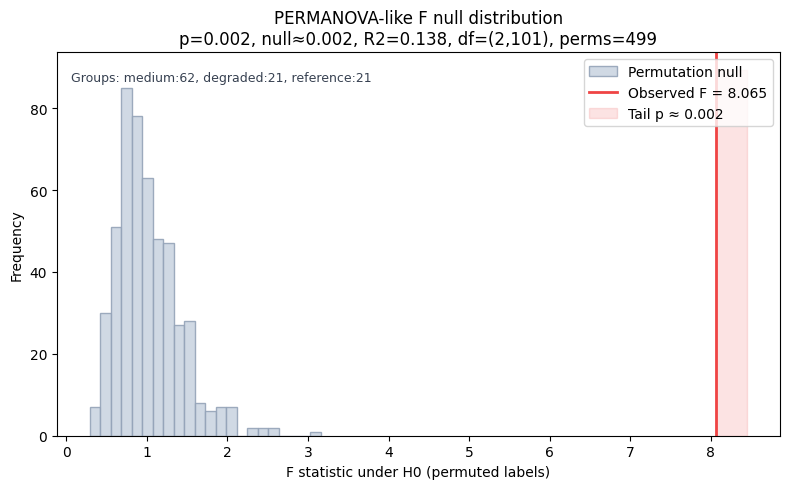

In [23]:
# Build null distribution for F and plot
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Try to use existing results; if missing, rebuild minimal inputs
try:
    F_obs = getattr(wrapper, "F_stat", None)
    p_obs = getattr(wrapper, "p_value", None)
    R2_obs = getattr(wrapper, "R2", None)
    dfB = getattr(wrapper, "df_between", None)
    dfW = getattr(wrapper, "df_within", None)
    n_perm = getattr(wrapper, "n_perm", 499)
except NameError:
    F_obs = p_obs = R2_obs = dfB = dfW = n_perm = None

if F_obs is None:
    try:
        F_obs = getattr(res_perm, "F_stat", None)
        p_obs = getattr(res_perm, "p_value", None)
        R2_obs = getattr(res_perm, "R2", None)
        dfB = getattr(res_perm, "df_between", None)
        dfW = getattr(res_perm, "df_within", None)
        n_perm = getattr(res_perm, "n_perm", 499)
    except NameError:
        pass

# If still missing, compute a minimal evaluation now (labels if available else quantiles; logz preferred)
if F_obs is None:
    # inputs from earlier cells
    fb, fs = "chemical", ("logz" if 'X_logz' in locals() and X_logz is not None else "raw")
    gm = 'labels' if 'g_labels' in locals() and g_labels is not None else 'quantiles'
    tmp = evaluate_pca_assessment(master, features_block=fb, features_subblock=fs, group_mode=gm, permutations=199)
    F_obs, p_obs, R2_obs = tmp.F_stat, tmp.p_value, tmp.R2
    dfB, dfW, n_perm = tmp.df_between, tmp.df_within, tmp.n_perm
    # also capture X and groups consistent with tmp
    X_plot, idx_tmp = prepare_feature_matrix(master, block=fb, subblock=fs, variables=None, standardize=True)
    if gm == 'labels':
        g_plot = build_groups_from_labels(master).reindex(idx_tmp).values
    else:
        g_plot = build_groups_from_quantiles(master).reindex(idx_tmp).values
else:
    # Recreate data used earlier if available
    if 'X' in locals() and 'groups' in locals() and X is not None:
        X_plot = X
        g_plot = groups.values
    else:
        fb = (wrapper.meta.get('features_block') if 'wrapper' in locals() and hasattr(wrapper, 'meta') else 'chemical')
        fs = (wrapper.meta.get('features_subblock') if 'wrapper' in locals() and hasattr(wrapper, 'meta') else 'raw')
        gm = (wrapper.meta.get('group_mode') if 'wrapper' in locals() and hasattr(wrapper, 'meta') else 'labels')
        X_plot, idx_tmp = prepare_feature_matrix(master, block=fb, subblock=fs, variables=None, standardize=True)
        if gm == 'labels':
            g_plot = build_groups_from_labels(master).reindex(idx_tmp).values
        else:
            g_plot = build_groups_from_quantiles(master).reindex(idx_tmp).values

# Compute null by permuting labels (reuse implementation logic)
def _ss_total(X):
    mu = X.mean(axis=0, keepdims=True)
    diff = X - mu
    return float(np.sum(diff * diff))

def _ss_between(X, groups):
    mu = X.mean(axis=0, keepdims=True)
    ssb = 0.0
    for g in np.unique(groups):
        idx = groups == g
        if not np.any(idx):
            continue
        n_g = int(idx.sum())
        mu_g = X[idx].mean(axis=0, keepdims=True)
        d = mu_g - mu
        ssb += n_g * float(np.sum(d * d))
    return float(ssb)

rng = np.random.default_rng(0)
ssT = _ss_total(X_plot)
levels = np.unique(g_plot)
k = len(levels)
n = X_plot.shape[0]
dfB_local = k - 1
dfW_local = n - k

# Build null vector
B = int(n_perm) if isinstance(n_perm, (int, np.integer)) else 499
F_null = np.empty(B)
for b in range(B):
    perm = rng.permutation(g_plot)
    ssB_p = _ss_between(X_plot, perm)
    ssW_p = ssT - ssB_p
    msB_p = ssB_p / dfB_local if dfB_local > 0 else np.nan
    msW_p = ssW_p / dfW_local if dfW_local > 0 else np.nan
    F_null[b] = msB_p / msW_p if msW_p > 0 else np.inf

# Tail area estimate consistent with counting scheme (+1)/(B+1)
p_tail = (np.sum(F_null >= F_obs) + 1) / (B + 1)

# Group counts for legend
from collections import Counter
counts = Counter(g_plot)
group_text = ", ".join([f"{k}:{v}" for k,v in counts.items()])

plt.figure(figsize=(8,5))
bins = max(10, int(np.sqrt(B)))
plt.hist(F_null, bins=bins, color="#cbd5e1", edgecolor="#94a3b8", alpha=0.9, label="Permutation null")
plt.axvline(F_obs, color="#ef4444", lw=2, label=f"Observed F = {F_obs:.3f}")

# Shade tail
xmin, xmax = plt.xlim()
xs = np.linspace(F_obs, xmax, 200)
plt.fill_between(xs, 0, plt.gca().get_ylim()[1], color="#ef4444", alpha=0.15, label=f"Tail p ≈ {p_tail:.3f}")

title = "PERMANOVA-like F null distribution"
subtitle = f"p={p_obs:.3f}, null≈{p_tail:.3f}, R2={R2_obs:.3f}, df=({dfB},{dfW}), perms={B}"
plt.title(title + "\n" + subtitle)
plt.xlabel("F statistic under H0 (permuted labels)")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.text(0.02, 0.95, f"Groups: {group_text}", transform=plt.gca().transAxes, va="top", fontsize=9, color="#374151")
plt.tight_layout()
plt.show()

## 10) Visualize directional one-sided null
This figure shows the observed directional statistic (degraded > reference across chemicals) against its permutation-based null distribution. The shaded tail highlights the one-sided p-value. We also annotate the chosen reference/degraded labels, mode (average or min), number of permutations, and top contributing variables.

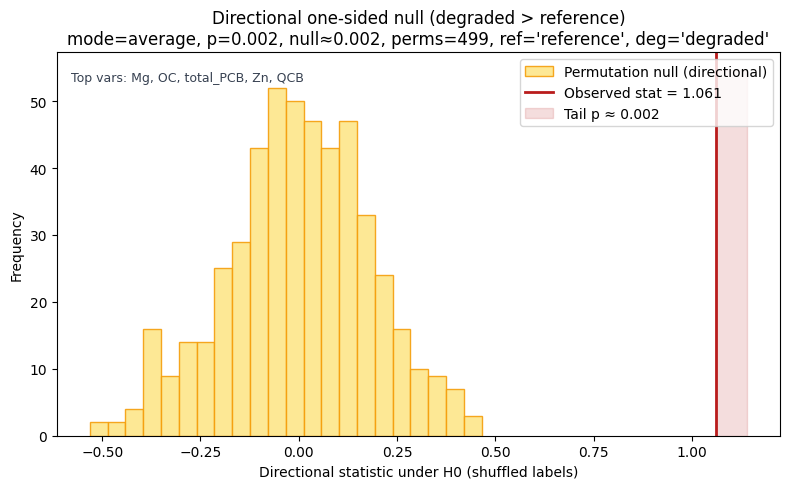

In [24]:
# Build null distribution for directional statistic and plot
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Prefer previously computed results from Section 7/dir_wrap; otherwise rebuild minimal inputs
try:
    stat_obs = dir_res_avg.statistic
    p_dir = dir_res_avg.p_value
    mode = dir_res_avg.mode
    ref_label = dir_res_avg.reference_label
    deg_label = dir_res_avg.degraded_label
    top_for_annot = sorted(dir_res_avg.per_variable, key=lambda k: dir_res_avg.per_variable[k].get('z', 0), reverse=True)[:5]
except NameError:
    # Fallback to wrapper result if available
    try:
        stat_obs = dir_wrap.statistic
        p_dir = dir_wrap.p_value
        mode = dir_wrap.mode
        ref_label = dir_wrap.reference_label
        deg_label = dir_wrap.degraded_label
        top_for_annot = sorted(dir_wrap.per_variable, key=lambda k: dir_wrap.per_variable[k].get('z', 0), reverse=True)[:5]
    except NameError:
        stat_obs = p_dir = None

# If still missing, rebuild minimal inputs and compute directional statistic
if stat_obs is None:
    fb, fs = "chemical", ("logz" if 'X_logz' in locals() and X_logz is not None else "raw")
    gm = 'labels' if 'g_labels' in locals() and g_labels is not None else 'quantiles'
    # build groups and choose labels
    if gm == 'labels':
        gtmp = build_groups_from_labels(master)
        # infer ref/deg
        cats = list(gtmp.cat.categories)
        ref_candidates = [c for c in cats if str(c).lower().startswith("ref")]
        deg_candidates = [c for c in cats if str(c).lower().startswith("deg")]
        ref_label = ref_candidates[0] if ref_candidates else min(cats)
        deg_label = deg_candidates[0] if deg_candidates else max(cats)
    else:
        gtmp = build_groups_from_quantiles(master)
        ref_label, deg_label = "bottom", "top"
    Xd, idxd = prepare_feature_matrix(master, block=fb, subblock=fs, variables=None, standardize=True)
    gtmp = gtmp.reindex(idxd)
    res_tmp = directional_mean_permutation_test(Xd, gtmp.values, reference_label=ref_label, degraded_label=deg_label, var_names=list(master[(fb, fs)].columns), standardize=True, permutations=199, mode="average")
    stat_obs, p_dir, mode = res_tmp.statistic, res_tmp.p_value, res_tmp.mode
    top_for_annot = sorted(res_tmp.per_variable, key=lambda k: res_tmp.per_variable[k].get('z', 0), reverse=True)[:5]

# Now build the permutation null for directional statistic using the same X and groups used above
if 'Xd' not in locals() or 'gtmp' not in locals():
    # Recreate from previously used variables if available
    try:
        # From Section 7
        Xd = X_use
        gtmp = g_use
        fb, fs = ("chemical", ("logz" if 'X_logz' in locals() and X_logz is not None else "raw"))
    except NameError:
        # Fall back to wrapper meta
        fb = (dir_wrap.meta.get('features_block') if 'dir_wrap' in locals() and hasattr(dir_wrap, 'meta') else 'chemical')
        fs = (dir_wrap.meta.get('features_subblock') if 'dir_wrap' in locals() and hasattr(dir_wrap, 'meta') else 'logz')
        gm = (dir_wrap.meta.get('group_mode') if 'dir_wrap' in locals() and hasattr(dir_wrap, 'meta') else 'labels')
        Xd, idxd = prepare_feature_matrix(master, block=fb, subblock=fs, variables=None, standardize=True)
        if gm == 'labels':
            gtmp = build_groups_from_labels(master).reindex(idxd).values
        else:
            gtmp = build_groups_from_quantiles(master).reindex(idxd).values

# Build null by shuffling labels between ref and deg only
labels = np.array([l for l in gtmp]) if not isinstance(gtmp, np.ndarray) else gtmp.copy()
mask_keep = np.isin(labels, [ref_label, deg_label])
X2 = Xd[mask_keep]
labs2 = labels[mask_keep]
rng = np.random.default_rng(0)
B = 499
def _dir_stat(Xa, la, ref, deg):
    # compute standardized per-variable differences and return average z-like (same as test default mode)
    sd = np.nanstd(Xa, axis=0, ddof=1)
    sd[sd == 0] = 1.0
    m_ref = np.nanmean(Xa[la == ref], axis=0)
    m_deg = np.nanmean(Xa[la == deg], axis=0)
    z = (m_deg - m_ref) / sd
    return float(np.mean(z))
S_null = np.empty(B)
for b in range(B):
    perm = rng.permutation(labs2)
    S_null[b] = _dir_stat(X2, perm, ref_label, deg_label)

p_tail = (np.sum(S_null >= stat_obs) + 1) / (B + 1)
top_txt = ", ".join(top_for_annot) if isinstance(top_for_annot[0], str) else ", ".join(top_for_annot)

plt.figure(figsize=(8,5))
bins = max(10, int(np.sqrt(B)))
plt.hist(S_null, bins=bins, color="#fde68a", edgecolor="#f59e0b", alpha=0.9, label="Permutation null (directional)")
plt.axvline(stat_obs, color="#b91c1c", lw=2, label=f"Observed stat = {stat_obs:.3f}")
xmin, xmax = plt.xlim()
xs = np.linspace(stat_obs, xmax, 200)
plt.fill_between(xs, 0, plt.gca().get_ylim()[1], color="#b91c1c", alpha=0.15, label=f"Tail p ≈ {p_tail:.3f}")
title = "Directional one-sided null (degraded > reference)"
subtitle = f"mode={mode}, p={p_dir:.3f}, null≈{p_tail:.3f}, perms={B}, ref='{ref_label}', deg='{deg_label}'"
plt.title(title + "\n" + subtitle)
plt.xlabel("Directional statistic under H0 (shuffled labels)")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.text(0.02, 0.95, f"Top vars: {top_txt}", transform=plt.gca().transAxes, va="top", fontsize=9, color="#374151")
plt.tight_layout()
plt.show()

{'F_obs': 8.06478886421225, 'p_value': 0.002, 'R2': 0.13770712779160174, 'df_between': 2, 'df_within': 101, 'n_perm': 499, 'p_tail': 0.002, 'group_counts': {'medium': 62, 'degraded': 21, 'reference': 21}}


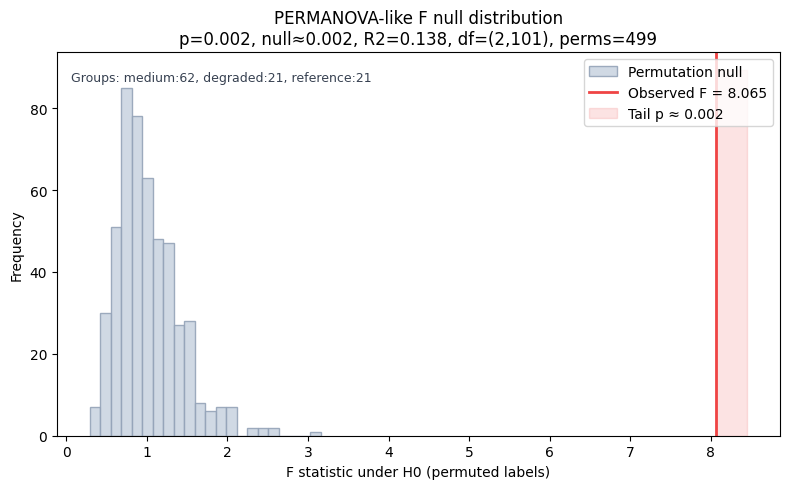

In [25]:
# Demo: plot_permanova_null_distribution (packaged helper)
from ecoindex import plot_permanova_null_distribution
import numpy as np
try:
    X_plot = X
    g_plot = groups.values if hasattr(groups, 'values') else groups
except NameError:
    fb = 'chemical'
    fs = 'logz' if 'X_logz' in locals() and X_logz is not None else 'raw'
    X_plot, idx_tmp = prepare_feature_matrix(master, block=fb, subblock=fs, variables=None, standardize=True)
    if 'g_labels' in locals() and g_labels is not None:
        g_plot = build_groups_from_labels(master).reindex(idx_tmp).values
    else:
        g_plot = build_groups_from_quantiles(master).reindex(idx_tmp).values
fig_f, ax_f, info_f = plot_permanova_null_distribution(X_plot, g_plot, permutations=499, seed=0)
print(info_f)

{'statistic': 1.0609697428537035, 'p_value': 0.002, 'p_tail': 0.002, 'mode': 'average', 'reference_label': 'reference', 'degraded_label': 'degraded', 'n_perm': 499, 'top_vars': ['v15', 'v19', 'v29', 'v25', 'v22']}


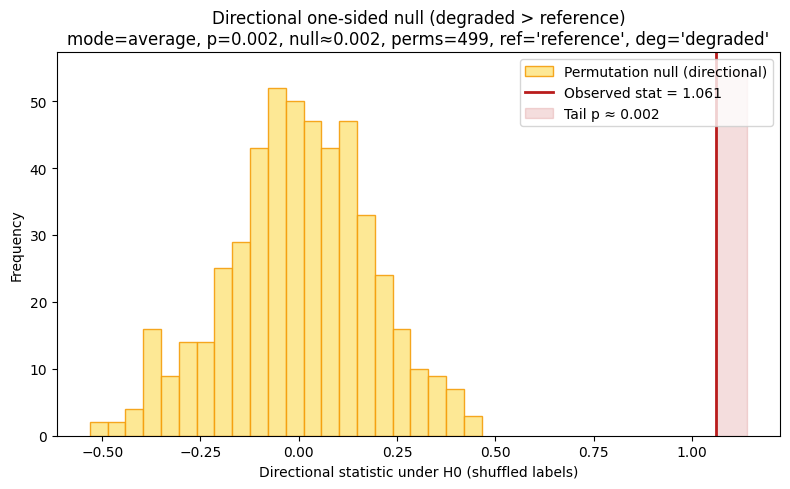

In [26]:
# Demo: plot_directional_null_distribution (packaged helper)
from ecoindex import plot_directional_null_distribution
import numpy as np
try:
    # Reuse from earlier directional section
    Xd_demo = X_use
    g_demo = g_use
    ref_demo = ref_label
    deg_demo = deg_label
except NameError:
    # Build minimal inputs
    fb = 'environmental'
    fs = 'raw' if 'X_logz' in locals() and X_logz is not None else 'raw'
    gm = 'labels' if ('g_labels' in locals() and g_labels is not None) else 'quantiles'
    Xd_demo, idxd_demo = prepare_feature_matrix(master, block=fb, subblock=fs, variables=None, standardize=True)
    if gm == 'labels':
        gtmp = build_groups_from_labels(master).reindex(idxd_demo)
        cats = list(gtmp.cat.categories)
        ref_candidates = [c for c in cats if str(c).lower().startswith('ref')]
        deg_candidates = [c for c in cats if str(c).lower().startswith('deg')]
        ref_demo = ref_candidates[0] if ref_candidates else min(cats)
        deg_demo = deg_candidates[0] if deg_candidates else max(cats)
        g_demo = gtmp
    else:
        gtmp = build_groups_from_quantiles(master).reindex(idxd_demo)
        ref_demo, deg_demo = 'bottom', 'top'
        g_demo = gtmp
fig_d, ax_d, info_d = plot_directional_null_distribution(Xd_demo, g_demo.values, ref_demo, deg_demo, mode='average', permutations=499, standardize=True)
print(info_d)

In [28]:
# Demo: run_assessment_suite to compute 5 tests in one call
from ecoindex import run_assessment_suite, prepare_feature_matrix
import numpy as np
try:
    X_suite = X
    labels_suite = groups.values if hasattr(groups, 'values') else groups
    var_names_suite = vars_ if 'vars_' in locals() else None
except NameError:
    # Rebuild minimal inputs as needed
    fb = 'environmental'
    fs = 'raw' if 'X_logz' in locals() and X_logz is not None else 'raw'
    X_suite, idx_suite = prepare_feature_matrix(master, block=fb, subblock=fs, variables=None, standardize=True)
    gtmp = (build_groups_from_labels(master) if ('g_labels' in locals() and g_labels is not None) else build_groups_from_quantiles(master)).reindex(idx_suite)
    labels_suite = gtmp.values
    var_names_suite = list(master[(fb, fs)].columns)
suite_summary = run_assessment_suite(X_suite, labels_suite, var_names=var_names_suite, permutations=499, seed=0, standardize_directional=True)
print(json.dumps(suite_summary, indent=2))

{
  "perm_direct": {
    "F": 8.06478886421225,
    "p": 0.002,
    "R2": 0.13770712779160174,
    "df_between": 2,
    "df_within": 101,
    "n_perm": 499,
    "method": "permutation_euclidean"
  },
  "perm_null_tail": {
    "p_tail": 0.002,
    "n_perm": 499
  },
  "loss": 0.3716674072928,
  "dir_avg": {
    "stat": 0.8666919808372746,
    "p": 0.002,
    "n_perm": 499,
    "mode": "average",
    "reference_label": "reference",
    "degraded_label": "degraded",
    "top_vars": [
      "Mg",
      "Ca",
      "OC",
      "Mn",
      "Na"
    ]
  },
  "dir_min": {
    "stat": -0.22541483367326604,
    "p": 0.038,
    "n_perm": 499,
    "mode": "min",
    "reference_label": "reference",
    "degraded_label": "degraded",
    "top_vars": [
      "Mg",
      "Ca",
      "OC",
      "Mn",
      "Na"
    ]
  }
}
